# Creating a stellar color-magnitude (or Hertzsprung-Russell) diagram

The Hertzsprung-Russell diagram (https://en.wikipedia.org/wiki/Hertzsprung–Russell_diagram) is a fundamental diagram in astronomy that displays important relationships between a the stellar color (or temperature) and absolute brightness (or luminosity). 

In this exercise, we will use existing stellar catalogs to produce the H-R diagram. 


In [1]:
# As a hint, we include the code block for Python modules that you will likely need to import:   
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

# For downloading files
from astropy.utils.data import download_file
from astropy.io import fits

import pyvo as vo
from pyvo import registry

## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore", module="astropy.io.votable.*")
warnings.filterwarnings("ignore", module="pyvo.utils.xml.*")

## Step 1: Find appropriate catalogs

We want to find a star catalog that has the available data to produce the H-R diagram, i.e., the absolute magnitudes (or both apparent magnitudes AND distances, so we can calculate the absolute magnitudes) in two optical bands (e.g., B and V). This would give us color. Or we need B- OR V- band magnitude and the stellar temperature. 

To simplify this problem, we want to find a catalog of an open cluster of stars, where all the stars were born around the same time and are located in one cluster. This simplifies the issue of getting accurate distances to the stars. One famous cluster is the Pleiades in the constellation of Taurus. So first we start by searching for an existing catalog with data on Pleiades that will provide the necessary information about the stars: magnitudes in two bands (e.g., B and V), which can be used to measure color, or temperature of the star plus one magnitude. 


### DATA DISCOVERY STEPS: 

Here is useful link for how the pyvo registry search works: https://pyvo.readthedocs.io/en/latest/registry/index.html

In [3]:
# All of these ways work... 
#resources = vo.regsearch(keywords=['star pleiades'])
#resources = registry.regtap.search(keywords=['star pleiades'])
resources = registry.search(keywords=['star pleiades'])

resources.to_table()

ivoid,cap_index,intf_index,intf_type,intf_role,std_version,query_type,result_type,wsdl_url,url_use,access_url,mirror_url,authenticated_only,security_method_id,ivoid_,cap_index_,cap_type,cap_description,standard_id,ivoid__,res_type,created,short_name,res_title,updated,content_level,res_description,reference_url,creator_seq,content_type,source_format,source_value,res_version,region_of_regard,waveband,rights,rights_uri,harvested_from
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,
object,int16,int16,object,object,object,object,object,object,object,object,object,int16,object,object,int16,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float32,object,object,object,object
ivo://cds.vizier/i/163,4,4,vs:paramhttp,std,,get,text/xml+votable,,base,http://vizier.u-strasbg.fr/viz-bin/conesearch/I/163/catalog?,,0,,ivo://cds.vizier/i/163,4,cs:conesearch,Cone search capability for table I/163/catalog (The catalog),ivo://ivoa.net/std/conesearch,ivo://cds.vizier/i/163,vs:catalogservice,2013-02-14T10:09:56,I/163,US Naval Observatory Pleiades Catalog (Van Flandern 1969),2019-06-21T18:30:00,research,"This catalog is a special subset of the Eichhorn et al. (1970) Pleiades catalog (see <I/90>) updated to B1950.0 positions and with proper motions added. It was prepared for the purpose of predicting occultations of Pleiades stars by the Moon, but is useful for general applications because it contains many faint stars not present in the current series of large astrometric catalogs.",http://cdsarc.u-strasbg.fr/cgi-bin/Cat?I/163,Van Flandern T.C.,catalog,bibcode,,12-Feb-1996,--,optical,public,,ivo://cds.vizier/registry
ivo://cds.vizier/i/258,4,4,vs:paramhttp,std,,get,text/xml+votable,,base,http://vizier.u-strasbg.fr/viz-bin/conesearch/I/258/catalog?,,0,,ivo://cds.vizier/i/258,4,cs:conesearch,Cone search capability for table I/258/catalog (Reduction data of 441 sources (Table 2 of paper)),ivo://ivoa.net/std/conesearch,ivo://cds.vizier/i/258,vs:catalogservice,2017-09-29T09:03:49,I/258,"Pleiades positions and proper motions (Wang+, 1996)",2019-06-21T18:30:00,research,"Based on a preliminary reference catalogue, combined with the catalogues PPM, ACRS and those in Eichhorn et al (1970, Cat. <I/90>), Jones (1973A&AS....9..313J) and Hertzsprung (1947AnLei..19a...1H), 33 exposures on 11 plates taken with the Zo-Se 40cm refractor (f=6895mm) in 86 years are reduced with the central overlapping technique, and high-precision positions and proper motions of 441 stars in the Pleiades astrometric standard region are obtained. The standard errors of star positions are less than +/-0.05arcsec, and the standard errors of proper motions for 90% stars in our reduction are less than +/-0.001arcsec/yr.",http://cdsarc.u-strasbg.fr/cgi-bin/Cat?I/258,"Wang J., Chen L., Zhao J., Jiang P.",catalog,bibcode,1996AcASn..37...68W,04-Jan-1999,--,optical,public,,ivo://cds.vizier/registry
ivo://cds.vizier/i/90,4,4,vs:paramhttp,std,,get,text/xml+votable,,base,http://vizier.u-strasbg.fr/viz-bin/conesearch/I/90/catalog?,,0,,ivo://cds.vizier/i/90,4,cs:conesearch,Cone search capability for table I/90/catalog (The catalogue (Tables III and IV of the paper)),ivo://ivoa.net/std/conesearch,ivo://cds.vizier/i/90,vs:catalogservice,1999-12-29T14:45:31,I/90,Positions of 502 Stars in Pleiades Region (Eichhorn+ 1970),2019-06-21T18:30:00,research,"The catalog contains the positions (equinox B1900.0 and epoch B1955.0) of 502 stars in a region of about 1.5 degrees square in the Pleiades cluster, centered on Eta Tau. These coordinates have been derived from measurements of stellar images obtained with 65 exposures of various durations on 14 photographic plates with two telescopes at McCormick Observatory and Van Vleck Observatory. The plates were reduced by the plate overlap method, which resulted in a high degree of systematic accuracy in the final positions. Data in the machine version include Hertzsprung number, color index, photovisual magn

In [5]:
resources = registry.search(keywords=['star pleiades'], includeaux=True)
print(len(resources.to_table()))

171


Note: The includeaux=True includes auxiliary services and therefore returns more services (171 versus 99). 

<font color=red>[TJ:  I'd remove the first and just leave the includeaux=true.  But this is odd to me anyway.  If you do not specify a service type, every registry result with those keywords should be returned.  I think.  I'm looking into it.]</font>

However, we know that we want to eventually access the search using <font color=blue>column information beyond RA and Dec, which is all that Simple Cone Search uses</font>. Therefore we need the service to be a TAP service, specifically. 

In [37]:
tap_services = registry.search(servicetype='tap', keywords=['star pleiades'], includeaux=True)
print(len(tap_services.to_table()))
tap_services.to_table()

72


ivoid,cap_index,intf_index,intf_type,intf_role,std_version,query_type,result_type,wsdl_url,url_use,access_url,mirror_url,authenticated_only,security_method_id,ivoid_,cap_index_,cap_type,cap_description,standard_id,ivoid__,res_type,created,short_name,res_title,updated,content_level,res_description,reference_url,creator_seq,content_type,source_format,source_value,res_version,region_of_regard,waveband,rights,rights_uri,harvested_from
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,
object,int16,int16,object,object,object,object,object,object,object,object,object,int16,object,object,int16,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float32,object,object,object,object
ivo://cds.vizier/i/163,3,3,vs:paramhttp,std,,,,,base,http://tapvizier.u-strasbg.fr/TAPVizieR/tap,,0,,ivo://cds.vizier/i/163,3,,,ivo://ivoa.net/std/tap#aux,ivo://cds.vizier/i/163,vs:catalogservice,2013-02-14T10:09:56,I/163,US Naval Observatory Pleiades Catalog (Van Flandern 1969),2019-06-21T18:30:00,research,"This catalog is a special subset of the Eichhorn et al. (1970) Pleiades catalog (see <I/90>) updated to B1950.0 positions and with proper motions added. It was prepared for the purpose of predicting occultations of Pleiades stars by the Moon, but is useful for general applications because it contains many faint stars not present in the current series of large astrometric catalogs.",http://cdsarc.u-strasbg.fr/cgi-bin/Cat?I/163,Van Flandern T.C.,catalog,bibcode,,12-Feb-1996,--,optical,public,,ivo://cds.vizier/registry
ivo://cds.vizier/i/258,3,3,vs:paramhttp,std,,,,,base,http://tapvizier.u-strasbg.fr/TAPVizieR/tap,,0,,ivo://cds.vizier/i/258,3,,,ivo://ivoa.net/std/tap#aux,ivo://cds.vizier/i/258,vs:catalogservice,2017-09-29T09:03:49,I/258,"Pleiades positions and proper motions (Wang+, 1996)",2019-06-21T18:30:00,research,"Based on a preliminary reference catalogue, combined with the catalogues PPM, ACRS and those in Eichhorn et al (1970, Cat. <I/90>), Jones (1973A&AS....9..313J) and Hertzsprung (1947AnLei..19a...1H), 33 exposures on 11 plates taken with the Zo-Se 40cm refractor (f=6895mm) in 86 years are reduced with the central overlapping technique, and high-precision positions and proper motions of 441 stars in the Pleiades astrometric standard region are obtained. The standard errors of star positions are less than +/-0.05arcsec, and the standard errors of proper motions for 90% stars in our reduction are less than +/-0.001arcsec/yr.",http://cdsarc.u-strasbg.fr/cgi-bin/Cat?I/258,"Wang J., Chen L., Zhao J., Jiang P.",catalog,bibcode,1996AcASn..37...68W,04-Jan-1999,--,optical,public,,ivo://cds.vizier/registry
ivo://cds.vizier/i/90,3,3,vs:paramhttp,std,,,,,base,http://tapvizier.u-strasbg.fr/TAPVizieR/tap,,0,,ivo://cds.vizier/i/90,3,,,ivo://ivoa.net/std/tap#aux,ivo://cds.vizier/i/90,vs:catalogservice,1999-12-29T14:45:31,I/90,Positions of 502 Stars in Pleiades Region (Eichhorn+ 1970),2019-06-21T18:30:00,research,"The catalog contains the positions (equinox B1900.0 and epoch B1955.0) of 502 stars in a region of about 1.5 degrees square in the Pleiades cluster, centered on Eta Tau. These coordinates have been derived from measurements of stellar images obtained with 65 exposures of various durations on 14 photographic plates with two telescopes at McCormick Observatory and Van Vleck Observatory. The plates were reduced by the plate overlap method, which resulted in a high degree of systematic accuracy in the final positions. Data in the machine version include Hertzsprung number, color index, photovisual magnitude, right ascension and declination and their standard errors, proper motion, and differences between the present position and previous works. Data for exposures, plates, and images measured, present in the published catalog, are not included in the machine version.",http://cdsarc.u-strasbg.fr/cgi-bin/Cat?I/90,"Eichhorn H., Googe W.D., Lukac C.F., Murphy J.K.",catalog,bibcode,1970MmRAS..73..125E,02-J

Note that this is now 72 services, but the data within the columns will be accessible for our purposes. 

#### Next, we need to find which of these has the columns of interest, i.e. magnitudes in two bands to create the color-magnitude diagram. 

For each resource element (i.e. row in the table above), there are useful attributes, which are described here: 
https://pyvo.readthedocs.io/en/latest/api/pyvo.registry.regtap.RegistryResource.html#pyvo.registry.regtap.RegistryResource

Based on these, we can create a search based on keywords in the description. <font color="red"> Internal: I guess this is what the FreeType function will eventually do, but currently in beta... </font>

In [35]:
def getrow( result, keywords=None ):
    ind = [] 
    keys = keywords.split()
    n_keys = len(keys)
    n_match = 0
    for i in range(len(result.to_table())):
        #print(resources[i].short_name)
        for each in keys: 
            if each in result[i].res_description:
                n_match = n_match + 1
        if n_match == n_keys:
            ind.append(i)
        n_match = 0
        
    return(ind)

In [39]:
ind = getrow(tap_services, keywords="magnitude color")
print(len(ind))

5


So using this we can reduce the matched tables to ones that are a bit more catered to our experiment. Note, that there is redundancy in some resources since these are available via multiple services and/or publishers. Therefore a bit more cleaning can be done to provide only the unique matches. 

In [43]:
tap_services.to_table()[ind]['ivoid']

ivo://cds.vizier/i/90
ivo://cds.vizier/j/aj/108/1722
ivo://cds.vizier/j/aj/156/275
ivo://cds.vizier/j/apj/348/557
ivo://cds.vizier/j/apj/856/23


In [44]:
def getunique( result, ind ):
    short_name = []
    unique_ind = []
    for i in range(len(ind)):
        short = result[ind[i]].short_name       
        if short not in short_name: 
            short_name.append(short)
            unique_ind.append(ind[i])
    
    return(unique_ind)

In [45]:
uniq_ind=getunique(tap_services, ind)
print(len(uniq_ind))

5


In [46]:
tap_services.to_table()[uniq_ind]['ivoid']

ivo://cds.vizier/i/90
ivo://cds.vizier/j/aj/108/1722
ivo://cds.vizier/j/aj/156/275
ivo://cds.vizier/j/apj/348/557
ivo://cds.vizier/j/apj/856/23


<font color=blue>This shows that in this case, all of our TAP results matching our keyword search are provided by Vizier and are unique.</font>

In [47]:
# To read the descriptions of the resulting matches:

for i in uniq_ind: 
    print("  ***  \n")
    print(tap_services[i].creators)
    print(tap_services[i].res_description)
    
    

  ***  

['Eichhorn H., Googe W.D., Lukac C.F., Murphy J.K.']
The catalog contains the positions (equinox B1900.0 and epoch B1955.0) of 502 stars in a region of about 1.5 degrees square in the Pleiades cluster, centered on Eta Tau. These coordinates have been derived from measurements of stellar images obtained with 65 exposures of various durations on 14 photographic plates with two telescopes at McCormick Observatory and Van Vleck Observatory. The plates were reduced by the plate overlap method, which resulted in a high degree of systematic accuracy in the final positions. Data in the machine version include Hertzsprung number, color index, photovisual magnitude, right ascension and declination and their standard errors, proper motion, and differences between the present position and previous works. Data for exposures, plates, and images measured, present in the published catalog, are not included in the machine version.
  ***  

['Kinman T.D., Suntzeff N.B., Kraft R.P.']
A complete 

<i> RESULT: Based on these, the first one (by Eichhorn et al) looks like a good start. </i>

### At this point, you can proceed to Step 2. 

-- OR --

### Try a different data discovery method! 

### Alternative Method: Use ADS to search for appropriate paper and access data via NED.

There are multiple paths for the data discovery. So it may also be that you know the paper that has the data you are interested in and want to access via the bibcode or authors, etc. 

In this case, let's assume that we have the information that the Eichhorn+1970 paper has the data that we need to create the H-R diagram: https://ui.adsabs.harvard.edu/abs/1970MmRAS..73..125E/abstract

We can either search by bibcode (1970MmRAS..73..125E) or "Eichhorn" to get the access_urls that will allow us to work with the data. 

Before this step, if may help to see the names of the fields available to use. Notice the following fields: 

"source_value" contains the bibcode information that we want; "creator_seq" lists the authors; 

and 

"access_url" provides the url from where the data can be accessed. 

<font color=red>[TJ:  But do you want to remove the keywords because you're looking for a specific bibcode?  As presented, this isn't an alternative method but a refinement or something.  Though it will take longer to get back all TAP services, that's all you can do with current pyvo.  With Markus' new functions, you can instead search on the bibcode or author in the RegTAP query itself.]</font>

In [48]:
## You already have this from above:
#tap_services = registry.search(servicetype='tap', keywords=['star pleiades'], includeaux=True)
print(tap_services.fieldnames)

('ivoid', 'cap_index', 'intf_index', 'intf_type', 'intf_role', 'std_version', 'query_type', 'result_type', 'wsdl_url', 'url_use', 'access_url', 'mirror_url', 'authenticated_only', 'security_method_id', 'ivoid_', 'cap_index_', 'cap_type', 'cap_description', 'standard_id', 'ivoid__', 'res_type', 'created', 'short_name', 'res_title', 'updated', 'content_level', 'res_description', 'reference_url', 'creator_seq', 'content_type', 'source_format', 'source_value', 'res_version', 'region_of_regard', 'waveband', 'rights', 'rights_uri', 'harvested_from')


First, Try using bibcode: 

In [223]:
bibcode = '1970MmRAS..73..125E' # Eichhorn
all_bibcodes = tap_services.getcolumn('source_value')
all_accessurl = tap_services.getcolumn('access_url')

match = np.where(all_bibcodes == bibcode)
# To see a few columns in this table for the matched rows:
print(tap_services.to_table()['short_name', 'access_url', 'creator_seq', 'source_value'][match])

# Let's grab the URLS only: 
url = all_accessurl[match]
print(url)

  short_name  ...     source_value   
------------- ... -------------------
J/A+A/329/101 ... 1998A&A...329..101R
['http://tapvizier.u-strasbg.fr/TAPVizieR/tap']


<font color=red>[TJ:  personally I fi nd this a bit more elegant.  You get the RegistryResource with the service attached.]</font>

In [52]:
bibcode = '1970MmRAS..73..125E' # Eichhorn
idx=-1
for s in tap_services.to_table():
    idx+=1
    if bibcode in s['source_value']:
        myidx=idx
        print(f"{s['short_name']}, {s['source_value']}, {s['access_url']}")
        break 
#  Note that using the to_table() lets you search the result 
#   easily using all columns.  But in the end, you want to get
#   back not an astropy table row, which you cannot use, but the
#   original RegistryResult that has the callable TAP service.  
myTAP=tap_services[myidx]

I/90, 1970MmRAS..73..125E, http://tapvizier.u-strasbg.fr/TAPVizieR/tap


<font color=blue>Note that the URL is a generic TAP url for Vizier.  All of its tables can be accessed by that same TAP services.  It'll be in the ADQL query itself that you specify the table name.  We'll see this below.</font>

Next, try using Author name: 

In [60]:
author = 'Eichhorn'
all_authors = tap_services.getcolumn('creator_seq')
all_accessurl = tap_services.getcolumn('access_url')

url=np.array([])
for record in resources: 
    names=record.creators
    if 'Eichhorn' in names[0]: 
        url = np.append(url,record.access_url)
        
print(url)


['http://tapvizier.u-strasbg.fr/TAPVizieR/tap']


These examples provide a few ways to access the information of interest. 

Below are a few other ways to see what the tap_service table contains. 

1. To view the column information: tap_services.to_table().columns() shows the metadata contained in the tap service. We will reference some of this columns below as we try to find the appropriate table. 

2. tap_services[index].describe(): The table with the tap_services output has, in our case, 72 tables listed and each includes metadata containing some human readable description. You can get the description for one case or for all the records by iterating through the resource. In the former case, we show the description for the Eichhorn data, whose index is uniq_ind[0]. The latter case also follows.  
    

In [224]:
print( tap_services.to_table().columns )

<TableColumns names=('ivoid','cap_index','intf_index','intf_type','intf_role','std_version','query_type','result_type','wsdl_url','url_use','access_url','mirror_url','authenticated_only','security_method_id','ivoid_','cap_index_','cap_type','cap_description','standard_id','ivoid__','res_type','created','short_name','res_title','updated','content_level','res_description','reference_url','creator_seq','content_type','source_format','source_value','res_version','region_of_regard','waveband','rights','rights_uri','harvested_from')>


In [284]:
tap_services[uniq_ind[0]].describe()   # For Eichhorm+1970 example. 

Table Access Protocol Service
Positions of 502 Stars in Pleiades Region (Eichhorn+ 1970)
Short Name: I/90
IVOA Identifier: ivo://cds.vizier/i/90
Base URL: http://tapvizier.u-strasbg.fr/TAPVizieR/tap

The catalog contains the positions (equinox B1900.0 and epoch B1955.0) of 502
stars in a region of about 1.5 degrees square in the Pleiades cluster,
centered on Eta Tau. These coordinates have been derived from measurements of
stellar images obtained with 65 exposures of various durations on 14
photographic plates with two telescopes at McCormick Observatory and Van Vleck
Observatory. The plates were reduced by the plate overlap method, which
resulted in a high degree of systematic accuracy in the final positions. Data
in the machine version include Hertzsprung number, color index, photovisual
magnitude, right ascension and declination and their standard errors, proper
motion, and differences between the present position and previous works. Data
for exposures, plates, and images measured, 

In [285]:
# To iterate over all the tables: 
for tapsvc in tap_services: 
    tapsvc.describe()

Table Access Protocol Service
US Naval Observatory Pleiades Catalog (Van Flandern 1969)
Short Name: I/163
IVOA Identifier: ivo://cds.vizier/i/163
Base URL: http://tapvizier.u-strasbg.fr/TAPVizieR/tap

This catalog is a special subset of the Eichhorn et al. (1970) Pleiades
catalog (see <I/90>) updated to B1950.0 positions and with proper motions
added. It was prepared for the purpose of predicting occultations of Pleiades
stars by the Moon, but is useful for general applications because it contains
many faint stars not present in the current series of large astrometric
catalogs.

Subjects: I/163
Waveband Coverage: optical
Table Access Protocol Service
Pleiades positions and proper motions (Wang+, 1996)
Short Name: I/258
IVOA Identifier: ivo://cds.vizier/i/258
Base URL: http://tapvizier.u-strasbg.fr/TAPVizieR/tap

Based on a preliminary reference catalogue, combined with the catalogues PPM,
ACRS and those in Eichhorn et al (1970, Cat. <I/90>), Jones
(1973A&AS....9..313J) and Hertzsprung 

## Step 2: Acquire the relevant data and make a plot!

<font color=blue>  Note that as discussed above, this TAP service is generic
   for all tables at CDS.  So when you ask for its tables
   you get all of them and need to find the precise name
   of the table you are looking for to put it in the query.
    But CDS has over 20k tables, so this query can take a while.</font>
   

In [53]:
tables = tap_services[uniq_ind[0]].service.tables

short_name = "I/90"
# find table name: 
for name in tables.keys():
    if short_name in name:  
        print(name)

VIII/90/first12
VI/90/notes
VI/90/quality
VI/90/maindata
VI/90/archives
VI/90/observer
I/90/catalog


We can write code to eliminate the other cases (e.g., VI or VIII...) but wanted to keep this cell to illustrate that the table name (which is required for the query) will likely include the short_name appended to "/catalog" (or "/table"). 
<font color=blue>[Note that this is up to the service provider to name.]</font>
But the other roman numeral catalogs are obviously different catalogs. Therefore try the below for a better match: 

In [214]:
# find (more restricted) table name: 
for name in tables.keys():
    if name.startswith(short_name):  
        print(name)
        tablename=name

I/90/catalog


In [215]:
query = 'SELECT * FROM "%s"' %tablename
print(query)
results = tap_services[uniq_ind[0]].search(query)
#results = taps[0].search(query)
results.to_table()

SELECT * FROM "I/90/catalog"


recno,Hertzsprung,CI,Ptm,RAB1900,e_RAs,DEB1900,e_DEs,rmsRA,rmsDE,rpmRA,rpmDE,DrpmRA,DrpmDE,DRA,DDE
,,mag,mag,deg,ms,deg,mas,,,mas / yr,mas / yr,mas / yr,mas / yr,arcsec,arcsec
int32,int16,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64
126,884,1.51,12.73,55.03883749999999,4.3,22.995927777777773,50,0.49,0.39,--,--,--,--,--,--
131,923,0.66,10.08,55.06343333333333,1.4,23.027888888888885,16,0.58,0.7,--,--,--,--,--,--
146,1021,1.26,10.42,55.12255833333332,1.5,23.011119444444443,18,0.41,0.64,--,--,--,--,--,--
90,712,1.05,13.21,54.91535416666666,5.8,23.042222222222218,65,0.5,0.42,--,--,--,--,--,--
107,802,0.0,14.44,54.97971666666666,5.2,23.035311111111106,61,0.4,0.33,--,--,--,--,--,--
124,882,1.15,12.55,55.038283333333325,3.4,23.09319722222222,43,0.42,0.48,--,--,--,--,--,--
111,815,0.82,12.01,54.986058333333325,2.7,23.118880555555553,33,0.61,0.49,--,--,--,--,--,--
66,580,0.3,12.65,54.82563333333333,9.7,22.981605555555554,96,0.25,0.22,--,--,--,--,--,--


We can access the column data as array using the .getcolumn(colname) attribute, where the colname is given in the table above. In particular the "CI" is the color index and "Ptm" is the photovisual magnitude. See https://vizier.u-strasbg.fr/viz-bin/VizieR?-source=I/90 for details about the columns. 

In [218]:
color = results.getcolumn('CI')
mag = results.getcolumn('Ptm') 

### Plotting... 
Note: The magnitudes here are apparent and therefore in plotting, the color-magnitude diagram is typically brightness increasing upwards (higher y-axis) so we will flip the y-axis here. 

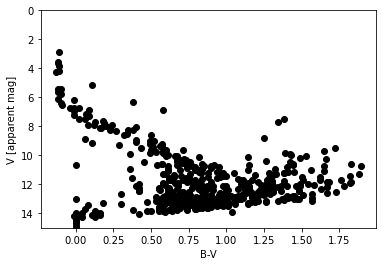

In [291]:
plt.ylim(15, 0)
plt.ylabel("V [apparent mag]")
plt.xlabel("B-V")

plt.plot(color, mag, 'o', color='black')

## Step 3. Compare with other color-magnitude diagrams for Pleiades:

There is nice discussion here: http://www.southastrodel.com/Page03009a.htm  about the color-magnitude diagram. Their Fig 4 looks slightly cleaner because part of this investigation was to select the 270 stars that are vetted members and restricted to stellar types more massive than K0. 

The dataset is from Raboud+1998 (1998A&A...329..101R)

Therefore in this next step, we will use the bibcode to select this data and overplot with the previous data to compare. 

We note that we did not discover this table above because alas! the description does not include the keywords (e.g. color, magnitude) that we used to refine our search. However, this table does have color and magnitude columns. <font color="red">Want to mention???[Teaser for future improvements... stay tuned!]: This motivates searching rather on the table UCDs, which would streamline the data discovery process and therefore make it more powerful. </font>

In [287]:
bibcode = '1998A&A...329..101R' # Raboud
all_bibcodes = tap_services.getcolumn('source_value')
all_shortnames = tap_services.getcolumn('short_name')

match = np.where(all_bibcodes == bibcode)

# Show relevant short_name (for Raboud paper): 
short_name = all_shortnames[match][0]
print(short_name)
print("----------")
ind = int(match[0])

tap_services[ind].describe()


J/A+A/329/101
----------
Table Access Protocol Service
Masses of Pleiades members (Raboud+ 1998)
Short Name: J/A+A/329/101
IVOA Identifier: ivo://cds.vizier/j/a+a/329/101
Base URL: http://tapvizier.u-strasbg.fr/TAPVizieR/tap

On the basis of the best available member list and duplicity information, we
have studied the radial distribution of 270 stars and multiple systems earlier
than K0 in the Pleiades. Five new long period spectroscopic binaries have been
identified from the CORAVEL observations. We have found a clear mass
segregation between binaries and single stars, which is explained by the
greater average mass of the multiple systems. The mass function of the single
stars and primaries appears to be significantly different. While the central
part of the cluster is spherical, the outer part is clearly elliptical, with
an ellipticity of 0.17. The various parameters describing the Pleiades are
(for a distance of 125pc): core radius r_c_=0.6 deg (1.4pc), tidal radius
r_t_=7.4 (16pc),

In [280]:
# Doing steps above to view table from Raboud+1998

tables = tap_services[ind].service.tables 

# find table name: 
for name in tables.keys():
    if short_name in name:  
        tablename = name
        
query = 'SELECT * FROM "%s"' %tablename
print(query)
results = tap_services[uniq_ind[0]].search(query)
results.to_table()

SELECT * FROM "J/A+A/329/101/table3"


recno,HII,Vmag,B-V,xpos,ypos,Dist,Mult,Rem,Mass,MassA,MassB,MassC,MassD
,,mag,mag,arcmin,arcmin,arcmin,,,Msun,Msun,Msun,Msun,Msun
int32,int32,float64,float64,float64,float64,float64,int16,object,float64,float64,float64,float64,float64
1,25,9.47,0.48,-55.52,22.81,60.02,1,,1.2,--,--,--,--
2,34,11.99,0.93,-53.62,33.49,63.22,1,,0.81,--,--,--,--
3,97,12.62,1.08,-48.27,52.86,71.58,2,IRB,1.21,0.73,0.48,--,--
4,102,10.51,0.71,-49.4,-53.25,72.64,2,IRB,1.45,0.97,0.45,--,--
5,120,10.79,0.7,-47.4,-26.36,54.23,2,SB1,1.53,0.98,0.55,--,--
6,129,11.47,0.88,-46.91,-21.06,51.42,1,,0.84,--,--,--,--
7,152,10.73,0.69,-46.07,-34.67,57.66,1,,0.99,--,--,--,--
8,153,7.51,0.15,-44.39,57.94,72.99,1,,1.74,--,--,--,--


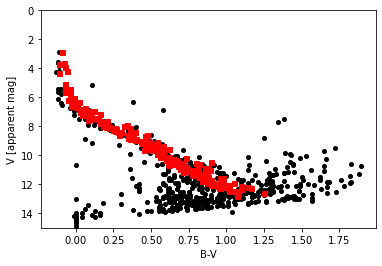

In [297]:
R98_color = results.getcolumn('B-V')
R98_mag = results.getcolumn('Vmag') 

plt.ylim(15, 0)
plt.ylabel("V [apparent mag]")
plt.xlabel("B-V")
plt.plot(color, mag, 'o', markersize=4.0, color='black') ## This is Eichhorn data
plt.plot(R98_color, R98_mag, 's', markersize=5.0, color='red') ## This is new data from Raboud+98


<font color="orange"> in progress... very rough and can do this better, or take out. But for fun...  </font>

## BONUS: Step 4: The CMD as a distance indicator! 

Since the y-axis above is apparent magnitude, we can use the obvious features (e.g., main sequence curve) to translate the apparent magnitudes to absolute magnitudes (by comparing to published H-R diagrams given in absolute magnitudes) and measure the distance to Pleiades! 


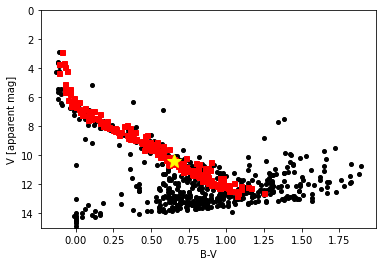

In [324]:
R98_color = results.getcolumn('B-V')
R98_mag = results.getcolumn('Vmag') 

sun_color = 0.65  # from http://www.astro.ucla.edu/~wright/magcolor.htm
sun_mag = 10.4   # Played with this value until it looked centered in relation (yellow star!) 

plt.ylim(15, 0)
plt.ylabel("V [apparent mag]")
plt.xlabel("B-V")
plt.plot(color, mag, 'o', markersize=4.0, color='black') ## This is Eichhorn data
plt.plot(R98_color, R98_mag, 's', markersize=5.0, color='red') ## This is new data from Raboud+98
plt.plot(sun_color, sun_mag, '*', markersize=15.0, color='yellow') ## This is our estimated center point


<font color=red>[TJ:  Where did the Vabs=4.8 come from?]</font>

In [313]:
# Another measure... use the Sun: 
Vabs = 4.8   ## Sun @ B-V 0.65
Vapp = 10.4  ## Based on rough reading of plot above at B-V = 0.65

dm= Vapp - Vabs   # distance module = 5log d / 10pc. 
dist = 10. ** (dm / 5. + 1.)
print("%10.1f pc " %dist)

     131.8 pc 


True distance to Pleaides is 136.2 pc ( https://en.wikipedia.org/wiki/Pleiades ). Not bad! 

## <font color="magenta"> TESS: Here are some things that we tried and didn't quite work. It seems that pyvo did not work quite as expected with the CDS tables. </font>

In [54]:
### TRYING STUFF TO DEBUG... TESS LOOK AT THIS. 
## This all works and copied from the pyvo/examples/notebook/simple_service_discovery.ipynb
taps = vo.regsearch(servicetype='tap',keywords=['HEASARC'])

tables=taps[0].service.tables
for table in tables:
    table.describe()

TAP_SCHEMA.columns
    Available columns

TAP_SCHEMA.key_columns
    Key/Foreign key pairs -- usused

TAP_SCHEMA.keys
    Joins between tables -- unused

TAP_SCHEMA.schemas
    Available schemas

TAP_SCHEMA.tables
    Available tables

"first"
    Faint Images of the Radio Sky at Twenty cm (FIRST)

a1
    HEAO 1 A1 X-Ray Source Catalog

a1point
    HEAO 1 A1 Lightcurves

a2lcpoint
    HEAO 1 A2 Pointed Lightcurves

a2lcscan
    HEAO 1 A2 Scanned Lightcurves

a2led
    HEAO 1 A2 LED Catalog

a2pic
    HEAO 1 A2 Piccinotti Catalog

a2point
    HEAO 1 A2 Pointing Catalog

a2rtraw
    HEAO 1 A2 Raw Rates

a2specback
    HEAO 1 A2 Spectra Background

a2spectra
    HEAO 1 A2 Spectra

a3
    HEAO 1 A3 MC LASS Catalog

a4
    HEAO 1 A4 Catalog of High-Energy X-Ray Sources

a4spectra
    HEAO 1 A4 Spectra

aavsovsx
    AAVSO International Variable Star Index

abell
    Abell Clusters

abellzcat
    Abell Clusters Measured Redshifts Catalog

acceptcat
    Archive of Chandra Cluster Entropy Profi

In [238]:
##### Now trying to get the same commands to work on the Pleaides CDS service:
## Note: tap_services is defined above
#type(tap_services)   # looks fine
#my_tables=tap_services[uniq_ind[0]].service.tables  #this works
#print(type(tables))    # This is for HEASARC ...
#print(type(my_tables))    # ... and looks same as this! So that's good.
#len(my_tables)      # there are lots of tables here, BUT ...
#print(type(my_tables[0])) # didn't work -- seems like the iterator doesn't work?
#my_tables[0].describe()    # doesn't work and nothing below works either.
#for table in my_tables:
#    print(type(table)) #.describe()